# Задание 2.2 - Введение в PyTorch

Для этого задания потребуется установить версию PyTorch 1.0

https://pytorch.org/get-started/locally/

В этом задании мы познакомимся с основными компонентами PyTorch и натренируем несколько небольших моделей.<br>
GPU нам пока не понадобится.

Основные ссылки:  
https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html  
https://pytorch.org/docs/stable/nn.html  
https://pytorch.org/docs/stable/torchvision/index.html  

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler, Sampler

from torchvision import transforms

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

# confirm PyTorch sees the GPU
from torch import cuda
assert cuda.is_available()
assert cuda.device_count() > 0
print(cuda.get_device_name(cuda.current_device()))

# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

GeForce GTX 1060


import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

## Как всегда, начинаем с загрузки данных

PyTorch поддерживает загрузку SVHN из коробки.

In [2]:
# First, lets load the dataset
data_train = dset.SVHN('./data/', split='train',
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('./data/', split='test', 
                      transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

Теперь мы разделим данные на training и validation с использованием классов `SubsetRandomSampler` и `DataLoader`.

`DataLoader` подгружает данные, предоставляемые классом `Dataset`, во время тренировки и группирует их в батчи.
Он дает возможность указать `Sampler`, который выбирает, какие примеры из датасета использовать для тренировки. Мы используем это, чтобы разделить данные на training и validation.

Подробнее: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [3]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler = SubsetRandomSampler(train_indices))
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler = SubsetRandomSampler(val_indices))

In [5]:
data_train[0]

(tensor([[[-1.5029, -1.8559, -1.8559,  ..., -0.7382, -0.5422, -0.4049],
          [-1.6010, -1.8755, -1.8755,  ..., -1.3657, -0.8363, -0.5225],
          [-1.3657, -1.7971, -1.8363,  ..., -1.6990, -1.4637, -0.7382],
          ...,
          [-0.4637, -0.4441, -0.5422,  ..., -0.1108, -0.1108, -0.1304],
          [-0.5029, -0.4637, -0.5422,  ...,  0.0069, -0.0716, -0.0716],
          [-0.4833, -0.4049, -0.4833,  ...,  0.0265, -0.0127, -0.1304]],
 
         [[-1.6118, -1.7490, -1.8667,  ..., -0.9255, -0.6902, -0.6510],
          [-1.4353, -1.7098, -1.8078,  ..., -1.4353, -1.0627, -0.6706],
          [-1.3961, -1.7882, -1.8667,  ..., -1.6314, -1.3765, -0.8471],
          ...,
          [-0.6118, -0.5922, -0.6510,  ..., -0.1608, -0.1412, -0.1412],
          [-0.5137, -0.6510, -0.7098,  ..., -0.1804, -0.1412, -0.1608],
          [-0.4745, -0.5922, -0.6510,  ..., -0.1608, -0.1412, -0.1216]],
 
         [[-1.6049, -1.9775, -1.9775,  ..., -1.2520, -1.2324, -1.1931],
          [-1.6637, -1.9186,

В нашей задаче мы получаем на вход изображения, но работаем с ними как с одномерными массивами. Чтобы превратить многомерный массив в одномерный, мы воспользуемся очень простым вспомогательным модулем `Flattener`.

In [4]:
sample, label = data_train[0]
print("SVHN data sample shape: ", sample.shape)
# As you can see, the data is shaped like an image

# We'll use a special helper module to shape it into a tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

SVHN data sample shape:  torch.Size([3, 32, 32])


И наконец, мы создаем основные объекты PyTorch:
- `nn_model` - собственно, модель с нейросетью
- `loss` - функцию ошибки, в нашем случае `CrossEntropyLoss`
- `optimizer` - алгоритм оптимизации, в нашем случае просто `SGD`

In [5]:
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )
nn_model.type(torch.FloatTensor)

# We will minimize cross-entropy between the ground truth and
# network predictions using an SGD optimizer
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)

## Тренируем!

Ниже приведена функция `train_model`, реализующая основной цикл тренировки PyTorch.

Каждую эпоху эта функция вызывает функцию `compute_accuracy`, которая вычисляет точность на validation, эту последнюю функцию предлагается реализовать вам.

In [6]:
# This is how to implement the same main train loop in PyTorch. Pretty easy, right?

def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, lr_scheduler = None):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        if epoch % 10 == 0:
            print(f'epoch number {epoch}')
        if lr_scheduler: 
            lr_scheduler.step()
        model.train() # Set model to training mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
#             x = x.to(device)
#             y = y.to(device)
            prediction = model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    n_correct = 0
    n_total = 0
    
    for x, y in loader:
        batch_pred = model(x).argmax(1)
        n_correct += (batch_pred == y).nonzero().size(0)
        n_total += y.size(0)
            
    return n_correct / n_total

In [7]:
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 3)

Average loss: 1.837873, Train accuracy: 0.403252, Val accuracy: 0.533684
Average loss: 1.463770, Train accuracy: 0.575351, Val accuracy: 0.605488
Average loss: 1.382684, Train accuracy: 0.618571, Val accuracy: 0.629855


## После основного цикла

Посмотрим на другие возможности и оптимизации, которые предоставляет PyTorch.

Добавьте еще один скрытый слой размера 100 нейронов к модели

In [20]:
%%time
# Since it's so easy to add layers, let's add some!

# TODO: Implement a model with 2 hidden layers of the size 100
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
       )
nn_model.type(torch.FloatTensor)

optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 4)

Average loss: 2.254477, Train accuracy: 0.181364, Val accuracy: 0.187018
Average loss: 2.242403, Train accuracy: 0.189759, Val accuracy: 0.187018
Average loss: 2.243937, Train accuracy: 0.189759, Val accuracy: 0.187018
Average loss: 2.245626, Train accuracy: 0.189759, Val accuracy: 0.187018
CPU times: user 15min 30s, sys: 17min 2s, total: 32min 32s
Wall time: 5min 27s


Добавьте слой с Batch Normalization

In [8]:
%%time
# We heard batch normalization is powerful, let's use it!
# TODO: Add batch normalization after each of the hidden layers of the network, before or after non-linearity
# Hint: check out torch.nn.BatchNorm1d

nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(100),
            nn.Linear(100, 100), 
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(100),
            nn.Linear(100, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10),
         )
# nn_model = nn_model.cuda
# nn_model.type(torch.cuda.FloatTensor)
nn_model.type(torch.FloatTensor)

optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 4)

Average loss: 2.112934, Train accuracy: 0.284425, Val accuracy: 0.308648
Average loss: 2.002828, Train accuracy: 0.332253, Val accuracy: 0.323186
Average loss: 1.971278, Train accuracy: 0.336433, Val accuracy: 0.307692
Average loss: 1.962768, Train accuracy: 0.327526, Val accuracy: 0.339567
CPU times: user 4min 34s, sys: 4min 45s, total: 9min 20s
Wall time: 1min 26s


Добавьте уменьшение скорости обучения по ходу тренировки.

In [16]:
%%time
# Learning rate annealing
# Reduce your learning rate 2x every 2 epochs
# Hint: look up learning rate schedulers in PyTorch. You might need to extend train_model function a little bit too!

nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(100),
            nn.Linear(100, 100), 
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(100),
            nn.Linear(100, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10),
         )

nn_model.type(torch.FloatTensor)

optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)
lr_reducer = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 4, 
                                                       lr_scheduler = lr_reducer)

Average loss: 2.123336, Train accuracy: 0.258284, Val accuracy: 0.271244
Average loss: 2.043825, Train accuracy: 0.281149, Val accuracy: 0.280254
Average loss: 2.026255, Train accuracy: 0.288844, Val accuracy: 0.298273
Average loss: 2.034632, Train accuracy: 0.287786, Val accuracy: 0.291516
CPU times: user 5min 3s, sys: 5min 16s, total: 10min 19s
Wall time: 1min 34s


# Визуализируем ошибки модели

Попробуем посмотреть, на каких изображениях наша модель ошибается.
Для этого мы получим все предсказания модели на validation set и сравним их с истинными метками (ground truth).

Первая часть - реализовать код на PyTorch, который вычисляет все предсказания модели на validation set.  
Чтобы это сделать мы приводим код `SubsetSampler`, который просто проходит по всем заданным индексам последовательно и составляет из них батчи. 

Реализуйте функцию `evaluate_model`, которая прогоняет модель через все сэмплы validation set и запоминает предсказания модели и истинные метки.

In [8]:
class SubsetSampler(Sampler):
    r"""Samples elements with given indices sequentially

    Arguments:
        indices (ndarray): indices of the samples to take
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)
    
    
def evaluate_model(model, dataset, indices):
    """
    Computes predictions and ground truth labels for the indices of the dataset
    
    Returns: 
    predictions: np array of booleans of model predictions
    grount_truth: np array of boolean of actual labels of the dataset
    """
    model.eval() # Evaluation mode
    
    sampler = SubsetSampler(indices)
    predictions = []
    ground_truth = []
    
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=sampler)
    
    for x, y in loader:
        predictions += list(model(x).argmax(1))
        ground_truth += list(y)

    return np.array(predictions), np.array(ground_truth)

# Evaluate model on validation
predictions, gt = evaluate_model(nn_model, data_train, val_indices)
assert len(predictions) == len(val_indices)
assert len(gt) == len(val_indices)
assert gt[100] == data_train[val_indices[100]][1]
assert np.any(np.not_equal(gt, predictions))

## Confusion matrix
Первая часть визуализации - вывести confusion matrix (https://en.wikipedia.org/wiki/Confusion_matrix ).

Confusion matrix - это матрица, где каждой строке соответствуют классы предсказанный, а столбцу - классы истинных меток (ground truth). Число с координатами `i,j` - это количество сэмплов класса `j`, которые модель считает классом `i`.

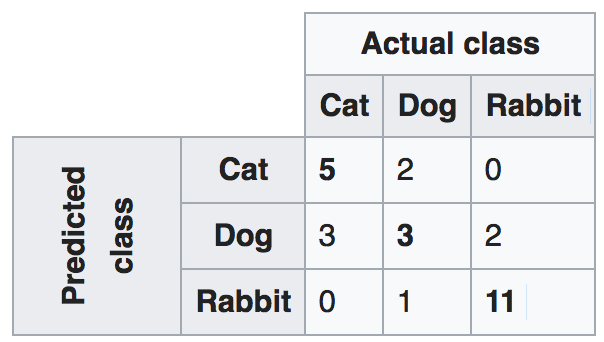

Для того, чтобы облегчить вам задачу, ниже реализована функция `visualize_confusion_matrix` которая визуализирует такую матрицу.  
Вам осталось реализовать функцию `build_confusion_matrix`, которая ее вычислит.

Результатом должна быть матрица 10x10.

In [9]:
def visualize_confusion_matrix(confusion_matrix):
    """
    Visualizes confusion matrix
    
    confusion_matrix: np array of ints, x axis - predicted class, y axis - actual class
                      [i][j] should have the count of samples that were predicted to be class i,
                      but have j in the ground truth
                     
    """
    # Adapted from 
    # https://stackoverflow.com/questions/2897826/confusion-matrix-with-number-of-classified-misclassified-instances-on-it-python
    assert confusion_matrix.shape[0] == confusion_matrix.shape[1]
    size = confusion_matrix.shape[0]
    fig = plt.figure(figsize=(10, 10))
    plt.title("Confusion matrix")
    plt.xlabel("ground truth")
    plt.ylabel("predicted")    
    res = plt.imshow(confusion_matrix, cmap='GnBu', interpolation='nearest')
    cb = fig.colorbar(res)
    plt.xticks(np.arange(size))
    plt.yticks(np.arange(size))
    for i, row in enumerate(confusion_matrix):
        for j, count in enumerate(row):
            plt.text(j, i, count, fontsize=14, horizontalalignment='center', verticalalignment='center')
    
def build_confusion_matrix(predictions, ground_truth):
    """
    Builds confusion matrix from predictions and ground truth

    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    
    Returns:
    np array of ints, (10,10), counts of samples for predicted/ground_truth classes
    """ 
    confusion_matrix = np.zeros((10, 10), np.int)
    
    for pred, gt in zip(predictions, ground_truth):
        confusion_matrix[pred][gt] += 1
    
    return confusion_matrix

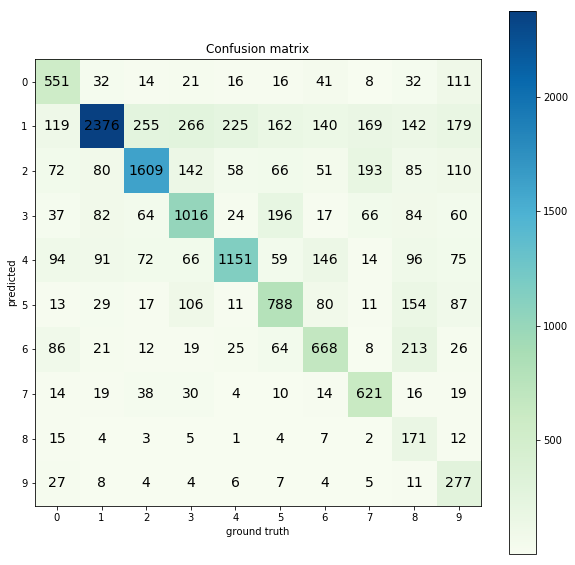

In [10]:
confusion_matrix = build_confusion_matrix(predictions, gt)
visualize_confusion_matrix(confusion_matrix)

Наконец, посмотрим на изображения, соответствующие некоторым элементам этой матрицы.

Как и раньше, вам дана функция `visualize_images`, которой нужно воспрользоваться при реализации функции `visualize_predicted_actual`. Эта функция должна вывести несколько примеров, соответствующих заданному элементу матрицы.

Визуализируйте наиболее частые ошибки и попробуйте понять, почему модель их совершает.

In [23]:
data_train_images = dset.SVHN('./data/', split='train')

def visualize_images(indices, data, title='', max_num=10):
    """
    Visualizes several images from the dataset
 
    indices: array of indices to visualize
    data: torch Dataset with the images
    title: string, title of the plot
    max_num: int, max number of images to display
    """
    to_show = min(len(indices), max_num)
    fig = plt.figure(figsize=(10, 2))
    fig.suptitle(title)
    for i, index in enumerate(indices[:to_show]):
        plt.subplot(1,to_show, i+1)
        plt.axis('off')
        sample = data[index][0]
        plt.imshow(sample)
        
def visualize_predicted_actual(predicted_class, gt_class, predictions, groud_truth, val_indices, data):
    """
    Visualizes images of a ground truth class which were predicted as the other class 
    
    predicted: int 0-9, index of the predicted class
    gt_class: int 0-9, index of the ground truth class
    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    val_indices: np array of ints, indices of validation samples
    """
    indices = val_indices[(predictions == predicted_class) & (gt == gt_class)]
    visualize_images(indices, data, f'Predicted {predicted_class}, labeled {gt_class}')

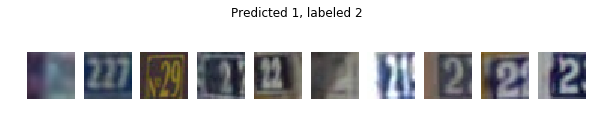

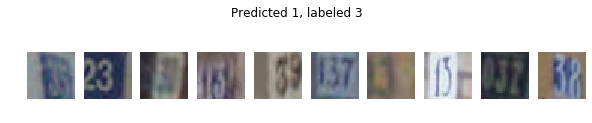

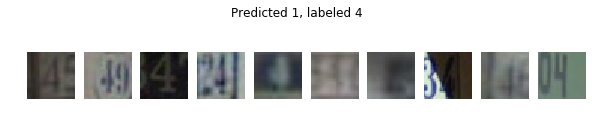

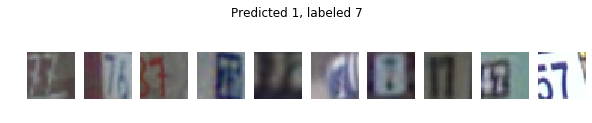

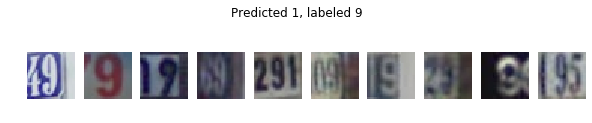

In [24]:
visualize_predicted_actual(1, 2, predictions, gt, np.array(val_indices), data_train_images)
visualize_predicted_actual(1, 3, predictions, gt, np.array(val_indices), data_train_images)
visualize_predicted_actual(1, 4, predictions, gt, np.array(val_indices), data_train_images)
visualize_predicted_actual(1, 7, predictions, gt, np.array(val_indices), data_train_images)
visualize_predicted_actual(1, 9, predictions, gt, np.array(val_indices), data_train_images)

# Переходим к свободным упражнениям!

Натренируйте модель как можно лучше - экспериментируйте сами!
Что следует обязательно попробовать:
- перебор гиперпараметров с помощью валидационной выборки
- другие оптимизаторы вместо SGD
- изменение количества слоев и их размеров
- наличие Batch Normalization

Но ограничиваться этим не стоит!

Точность на валидацонной выборке должна быть доведена до **60%**

За лучший результат в группе вы получите дополнительные баллы :)

In [30]:
import math

In [39]:
int(math.log(10.0 ** -4, 10)) + 4

1

In [56]:
%%time

nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(100),
            nn.Linear(100, 100), 
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(100),
            nn.Dropout(p = 0.3),
            nn.Linear(100, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10),
         )
total = np.zeros((4, 4, 1))
for i in 10.0 ** np.arange(-4, 0):
    for j in 10.0 ** np.arange(-4, 0):
        print(f'learning rate: {i}, weight_decay: {j}')
        optimizer = optim.Adam(nn_model.parameters(), lr=i, weight_decay=j)
        loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 10)
#         print(f'{i} {j}')
#         print(f'{int(math.log(i, 10)) + 3} {int(math.log(j, 10)) + 3}')
#         print(f'{loss_history}')
        total[int(math.log(i, 10)) + 3][int(math.log(j, 10)) + 3] = np.mean(loss_history)   

learning rate: 0.0001, weight_decay: 0.0001
Average loss: 1.793238, Train accuracy: 0.411545, Val accuracy: 0.597092
Average loss: 1.197760, Train accuracy: 0.621267, Val accuracy: 0.707051
Average loss: 0.998809, Train accuracy: 0.686687, Val accuracy: 0.736400
Average loss: 0.886028, Train accuracy: 0.721581, Val accuracy: 0.762064
Average loss: 0.819126, Train accuracy: 0.742723, Val accuracy: 0.767729
Average loss: 0.778686, Train accuracy: 0.754957, Val accuracy: 0.782404
Average loss: 0.742643, Train accuracy: 0.767328, Val accuracy: 0.783428
Average loss: 0.712062, Train accuracy: 0.777412, Val accuracy: 0.795782
Average loss: 0.688402, Train accuracy: 0.784664, Val accuracy: 0.794553
Average loss: 0.665251, Train accuracy: 0.791694, Val accuracy: 0.810798
learning rate: 0.0001, weight_decay: 0.001
Average loss: 0.649892, Train accuracy: 0.795977, Val accuracy: 0.814211
Average loss: 0.636075, Train accuracy: 0.800635, Val accuracy: 0.815303
Average loss: 0.621577, Train accurac

Average loss: 1.906934, Train accuracy: 0.331621, Val accuracy: 0.338066
Average loss: 1.923721, Train accuracy: 0.329659, Val accuracy: 0.320456
Average loss: 1.909087, Train accuracy: 0.334283, Val accuracy: 0.356358
Average loss: 1.952163, Train accuracy: 0.316794, Val accuracy: 0.371237
learning rate: 0.01, weight_decay: 0.1
Average loss: 2.249041, Train accuracy: 0.190339, Val accuracy: 0.187154
Average loss: 2.250468, Train accuracy: 0.189725, Val accuracy: 0.187154
Average loss: 2.250455, Train accuracy: 0.189725, Val accuracy: 0.187154
Average loss: 2.250367, Train accuracy: 0.189725, Val accuracy: 0.187154
Average loss: 2.250390, Train accuracy: 0.189725, Val accuracy: 0.187154
Average loss: 2.250282, Train accuracy: 0.189725, Val accuracy: 0.187154
Average loss: 2.250394, Train accuracy: 0.189725, Val accuracy: 0.187154
Average loss: 2.250377, Train accuracy: 0.189725, Val accuracy: 0.187154
Average loss: 2.250380, Train accuracy: 0.189725, Val accuracy: 0.187154
Average loss

In [59]:
%%time

nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(100),
            nn.Linear(100, 100), 
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(100),
            nn.Dropout(p = 0.3),
            nn.Linear(100, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10),
         )
optimizer = optim.Adam(nn_model.parameters(), lr=0.0001, weight_decay=0.01)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 100)

Average loss: 1.853180, Train accuracy: 0.387349, Val accuracy: 0.565422
Average loss: 1.278876, Train accuracy: 0.592260, Val accuracy: 0.647328
Average loss: 1.074208, Train accuracy: 0.663925, Val accuracy: 0.701454
Average loss: 0.966794, Train accuracy: 0.700491, Val accuracy: 0.735376
Average loss: 0.894424, Train accuracy: 0.725369, Val accuracy: 0.761859
Average loss: 0.844189, Train accuracy: 0.741699, Val accuracy: 0.765477
Average loss: 0.803616, Train accuracy: 0.755418, Val accuracy: 0.773463
Average loss: 0.773052, Train accuracy: 0.765331, Val accuracy: 0.784588
Average loss: 0.754519, Train accuracy: 0.772071, Val accuracy: 0.790868
Average loss: 0.729495, Train accuracy: 0.778675, Val accuracy: 0.797625
Average loss: 0.718290, Train accuracy: 0.784476, Val accuracy: 0.803563
Average loss: 0.699989, Train accuracy: 0.788827, Val accuracy: 0.799263
Average loss: 0.682600, Train accuracy: 0.794117, Val accuracy: 0.803222
Average loss: 0.671620, Train accuracy: 0.798894, V

In [60]:
# Как всегда, в конце проверяем на test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(nn_model, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)

Test accuracy: 0.6028
